In [5]:
!git clone https://github.com/Ehsanacc/iMIAP.git

!pip install scikit-fuzzy

fatal: destination path 'iMIAP' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.4 MB/s eta 0:00:0000:01


Processing image 1.jpg...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segmented images saved for image 1.jpg
Processing image 2.jpg...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segmented images saved for image 2.jpg
Processing image 3.bmp...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Segmented images saved for image 3.bmp


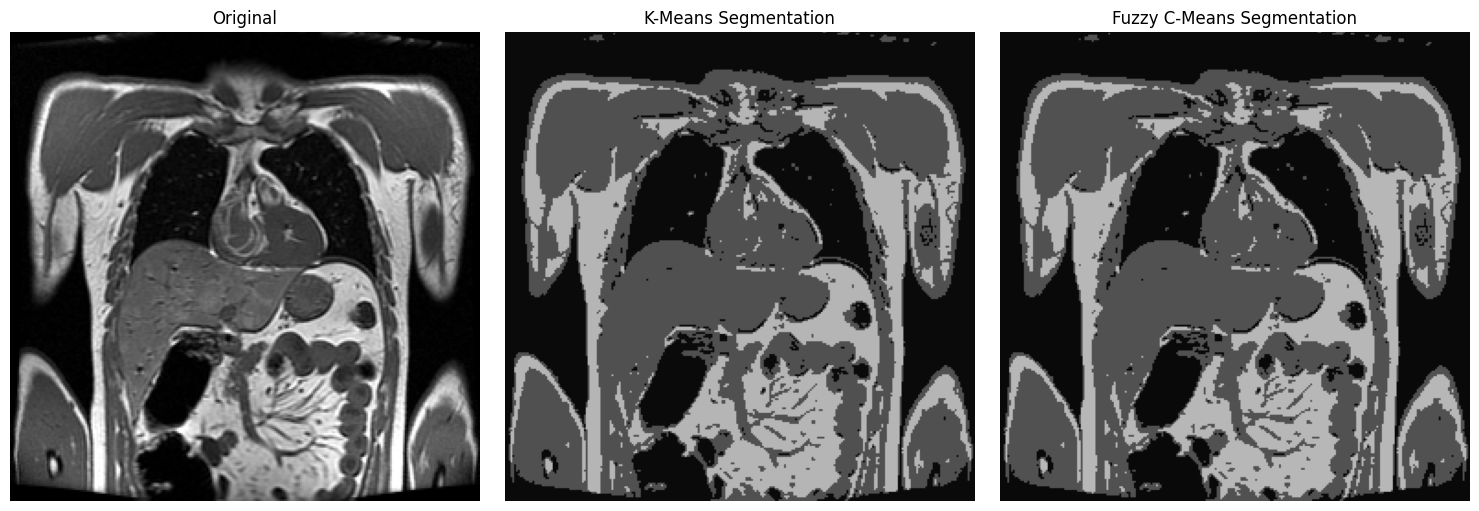

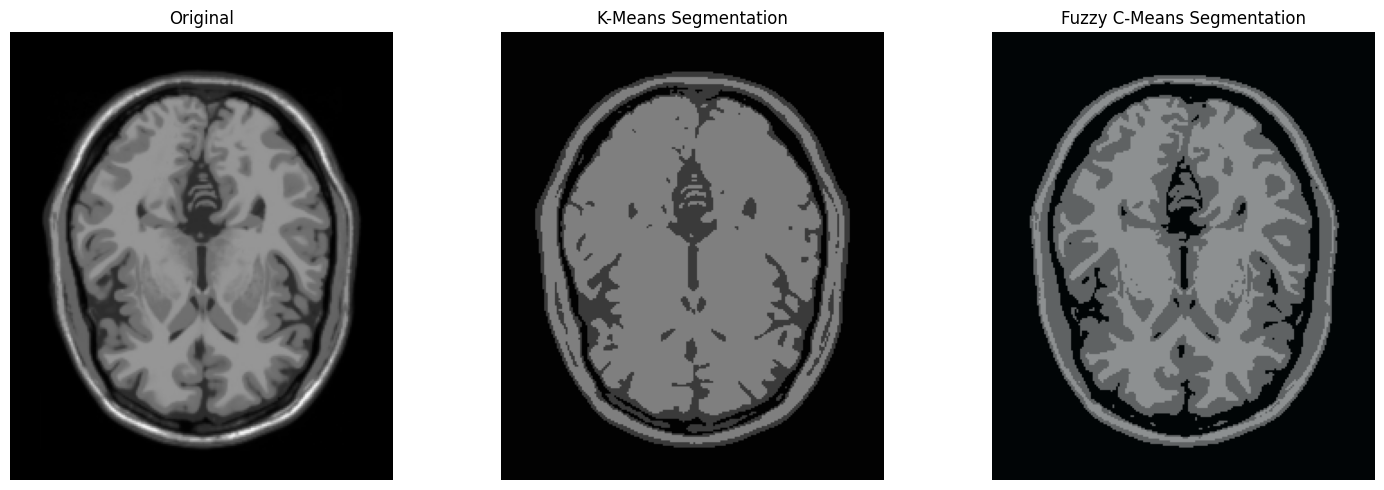

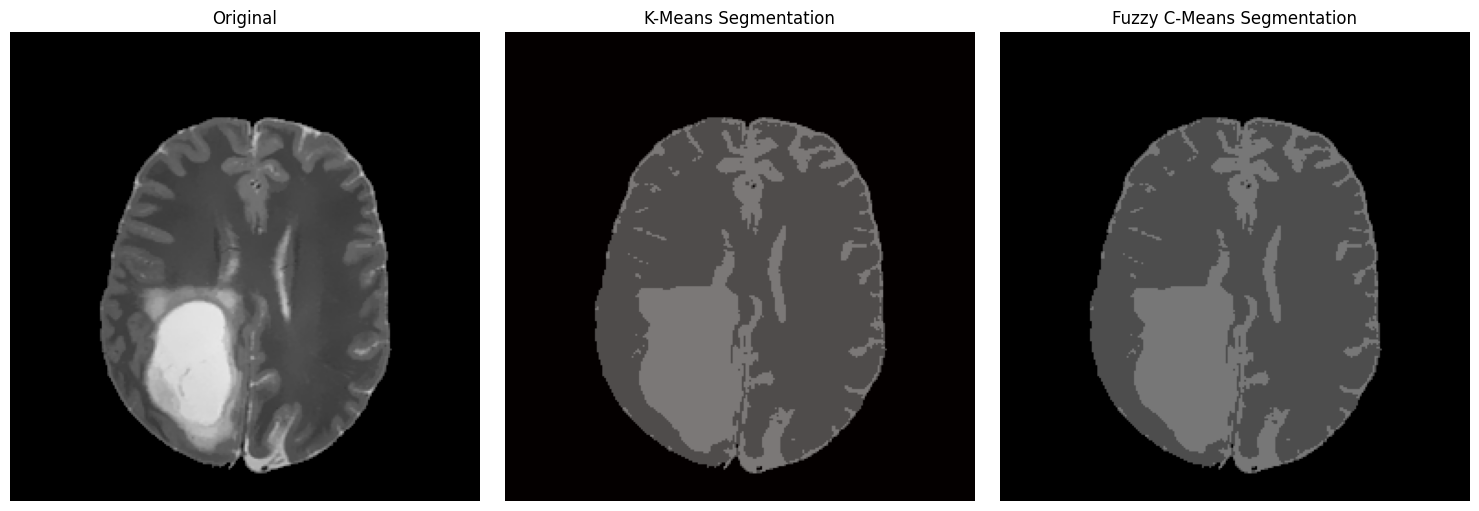

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

# Define input and output directories
input_dir = "/kaggle/working/iMIAP/Assignment 2/Q2"
output_dir = "/kaggle/working/iMIAP/Assignment 2/Q2_segmented"
Path(output_dir).mkdir(exist_ok=True)

# Number of clusters (can be tuned)
n_clusters = 3

def preprocess_image(image_path):
    """Load and preprocess the image."""
    # Read image in BGR and convert to LAB
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Flatten image to (n_pixels, 3) for clustering
    if image_path.endswith('.bmp'):
        pixels = img_lab.reshape(-1, 1)
    else:
        pixels = img_lab.reshape(-1, 3)
    # Normalize pixel values to [0, 1]
    pixels = pixels / 255.0
    return img_rgb, img_lab, pixels

def kmeans_segmentation(pixels, n_clusters, img_shape):
    """Apply K-Means clustering."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)
    # Create segmented image using cluster centers
    centers = kmeans.cluster_centers_ * 255.0  # Denormalize
    segmented = centers[labels].reshape(img_shape)
    return segmented.astype(np.uint8), labels

def fcm_segmentation(pixels, n_clusters, img_shape):
    """Apply Fuzzy C-Means clustering."""
    # Transpose pixels for skfuzzy (expects (n_features, n_samples))
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels.T, n_clusters, m=2, error=0.005, maxiter=1000, init=None
    )
    # Get cluster labels (highest membership)
    labels = np.argmax(u, axis=0)
    # Create segmented image using cluster centers
    centers = cntr * 255.0  # Denormalize
    segmented = centers[labels].reshape(img_shape)
    return segmented.astype(np.uint8), labels

def visualize_and_save(original, kmeans_seg, fcm_seg, filename, output_dir):
    """Visualize original and segmented images, then save results."""
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')
    
    # K-Means segmented
    plt.subplot(1, 3, 2)
    plt.title("K-Means Segmentation")
    plt.imshow(cv2.cvtColor(kmeans_seg, cv2.COLOR_LAB2RGB))
    plt.axis('off')
    
    # FCM segmented
    plt.subplot(1, 3, 3)
    plt.title("Fuzzy C-Means Segmentation")
    plt.imshow(cv2.cvtColor(fcm_seg, cv2.COLOR_LAB2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    # plt.savefig(os.path.join(output_dir, f"vis_{filename}"))
    # plt.close()
    
    # Save segmented images
    # Ensure output filename has .jpg extension for consistency
    # output_filename = os.path.splitext(filename)[0] + ".jpg"
    # cv2.imwrite(os.path.join(output_dir, f"kmeans_{output_filename}"), cv2.cvtColor(kmeans_seg, cv2.COLOR_LAB2BGR))
    # cv2.imwrite(os.path.join(output_dir, f"fcm_{output_filename}"), cv2.cvtColor(fcm_seg, cv2.COLOR_LAB2BGR))

def main():
    # Process each image in the Q2 folder
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(input_dir, filename)
            print(f"Processing {filename}...")
            
            # Preprocess
            img_rgb, img_lab, pixels = preprocess_image(image_path)
            
            # Apply K-Means
            kmeans_seg, kmeans_labels = kmeans_segmentation(pixels, n_clusters, img_lab.shape)
            
            # Apply Fuzzy C-Means
            fcm_seg, fcm_labels = fcm_segmentation(pixels, n_clusters, img_lab.shape)
            
            # Visualize and save
            visualize_and_save(img_rgb, kmeans_seg, fcm_seg, filename, output_dir)
            print(f"Segmented images saved for {filename}")

if __name__ == "__main__":
    main()

In [16]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from skfuzzy import cmeans
import matplotlib.pyplot as plt

# Step 1: Load pretrained ResNet model
def load_resnet_model():
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.eval()  # Set to evaluation mode
    # Remove the final fully connected layer to get feature maps
    model = torch.nn.Sequential(*list(model.children())[:-2])
    return model

# Step 2: Preprocess and extract feature maps
def extract_feature_maps(image_path, model, device, target_size=(224, 224)):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, target_size)
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Extract feature maps
    with torch.no_grad():
        feature_maps = model(input_tensor)
    
    # Convert feature maps to numpy
    feature_maps = feature_maps.squeeze(0).cpu().numpy()  # Shape: (C, H', W')
    
    # Resize feature maps to match original image size using interpolation
    feature_maps_resized = []
    for i in range(feature_maps.shape[0]):
        fmap = feature_maps[i]
        fmap_resized = cv2.resize(fmap, target_size, interpolation=cv2.INTER_LINEAR)
        feature_maps_resized.append(fmap_resized)
    
    feature_maps_resized = np.array(feature_maps_resized)  # Shape: (C, H, W)
    
    return original_image, feature_maps_resized

# Step 3: Combine original image and feature maps
def combine_features(original_image, feature_maps):
    # Normalize original image to [0, 1]
    original_image = original_image.astype(float) / 255.0
    
    # Reshape images and feature maps for clustering
    h, w, c = original_image.shape
    original_flat = original_image.reshape(-1, c)  # Shape: (H*W, 3)
    
    # Normalize feature maps to [0, 1]
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())
    feature_maps_flat = feature_maps.transpose(1, 2, 0).reshape(-1, feature_maps.shape[0])  # Shape: (H*W, C)
    
    # Concatenate original image pixels and feature maps
    combined_features = np.concatenate([original_flat, feature_maps_flat], axis=1)  # Shape: (H*W, 3+C)
    
    return combined_features, h, w

# Step 4: K-Means segmentation
def kmeans_segmentation(combined_features, h, w, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_features)
    segmented_image = labels.reshape(h, w)
    return segmented_image

# Step 5: Fuzzy C-Means segmentation
def fuzzy_cmeans_segmentation(combined_features, h, w, n_clusters=3):
    # Transpose data for fuzzy c-means (expects shape: (features, samples))
    cntr, u, _, _, _, _, _ = cmeans(combined_features.T, c=n_clusters, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    segmented_image = labels.reshape(h, w)
    return segmented_image

# Step 6: Visualize results
def visualize_results(original_image, kmeans_result, fcm_result, image_path):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('K-Means Segmentation')
    plt.imshow(kmeans_result, cmap='viridis')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Fuzzy C-Means Segmentation')
    plt.imshow(fcm_result, cmap='viridis')
    plt.axis('off')

    plt.tight_layout()
    # plt.savefig(f"segmentation_result_{os.path.basename(image_path)}.png")
    # plt.close()

# Main function to process all images in Q2 folder
def process_images(folder_path, n_clusters=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_resnet_model().to(device)
    
    for image_name in os.listdir(folder_path):
        if image_name.endswith(('.bmp', '.jpg')):
            image_path = os.path.join(folder_path, image_name)
            
            # Extract feature maps
            original_image, feature_maps = extract_feature_maps(image_path, model, device)
            
            # Combine features
            combined_features, h, w = combine_features(original_image, feature_maps)
            
            # Perform segmentation
            kmeans_result = kmeans_segmentation(combined_features, h, w, n_clusters)
            fcm_result = fuzzy_cmeans_segmentation(combined_features, h, w, n_clusters)
            
            # Visualize results
            visualize_results(original_image, kmeans_result, fcm_result, image_path)

if __name__ == '__main__':
    folder_path = '/kaggle/working/iMIAP/Assignment 2/Q2'  # Path to Q2 folder
    n_clusters = 3      # Number of clusters for segmentation
    process_images(folder_path, n_clusters)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


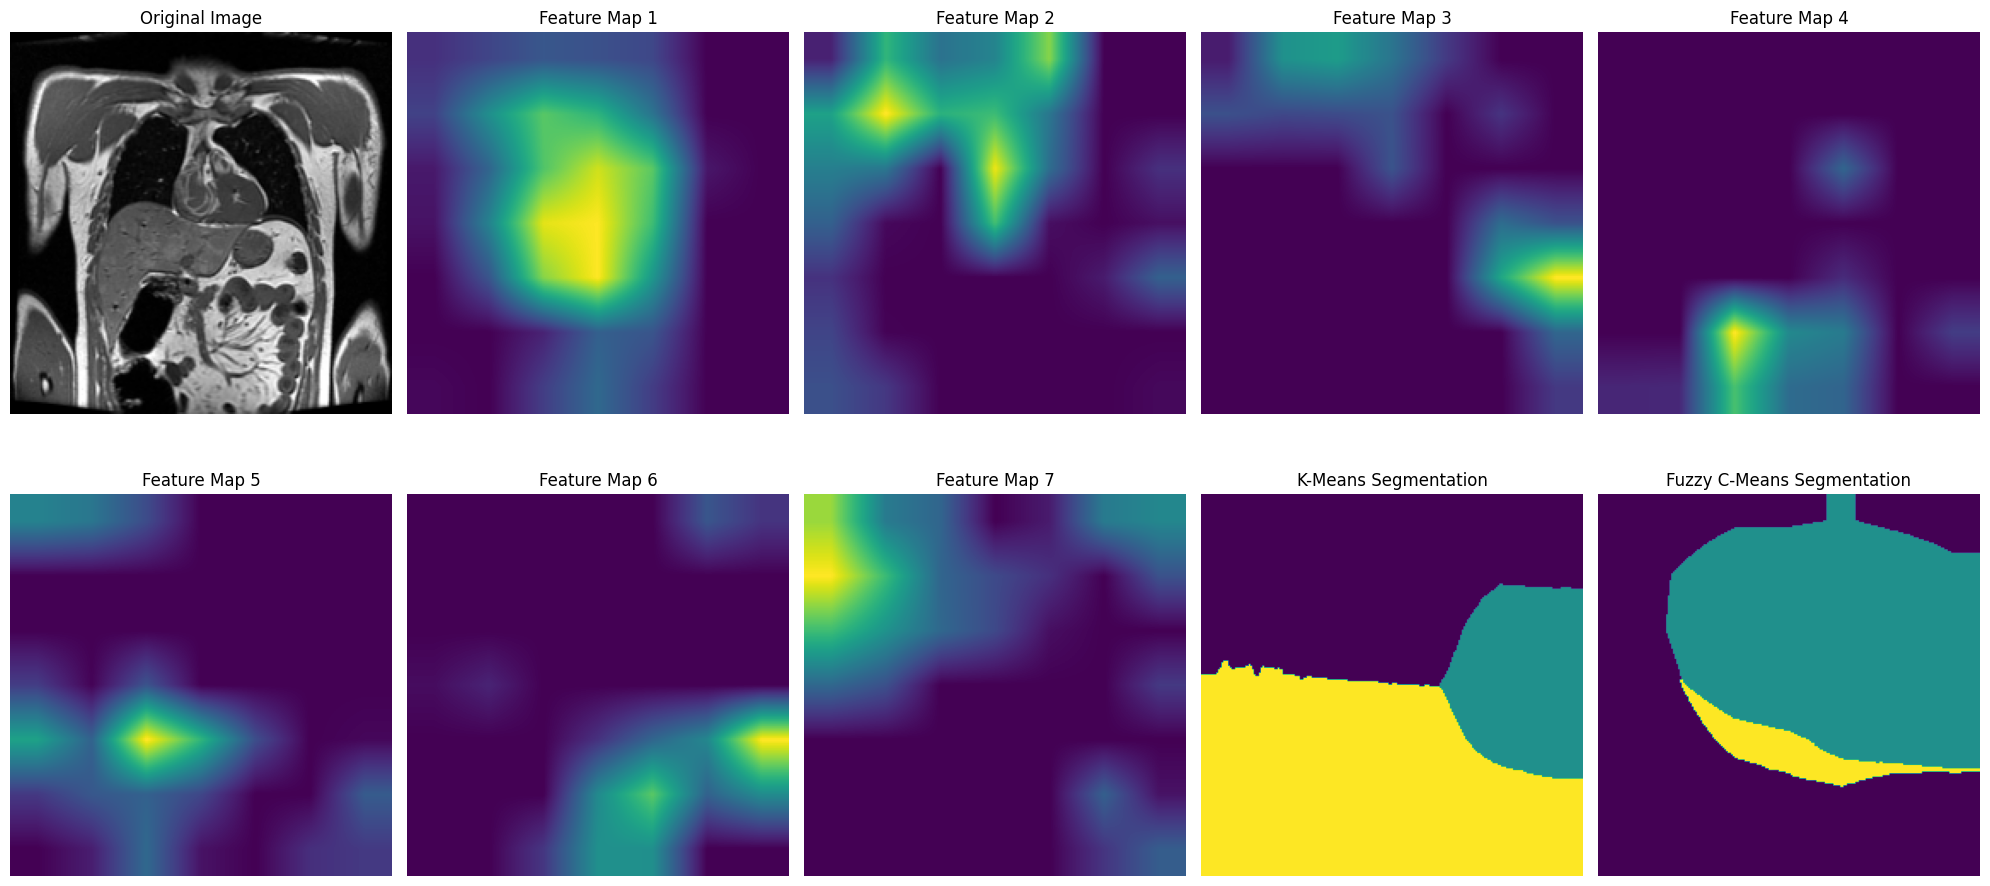

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


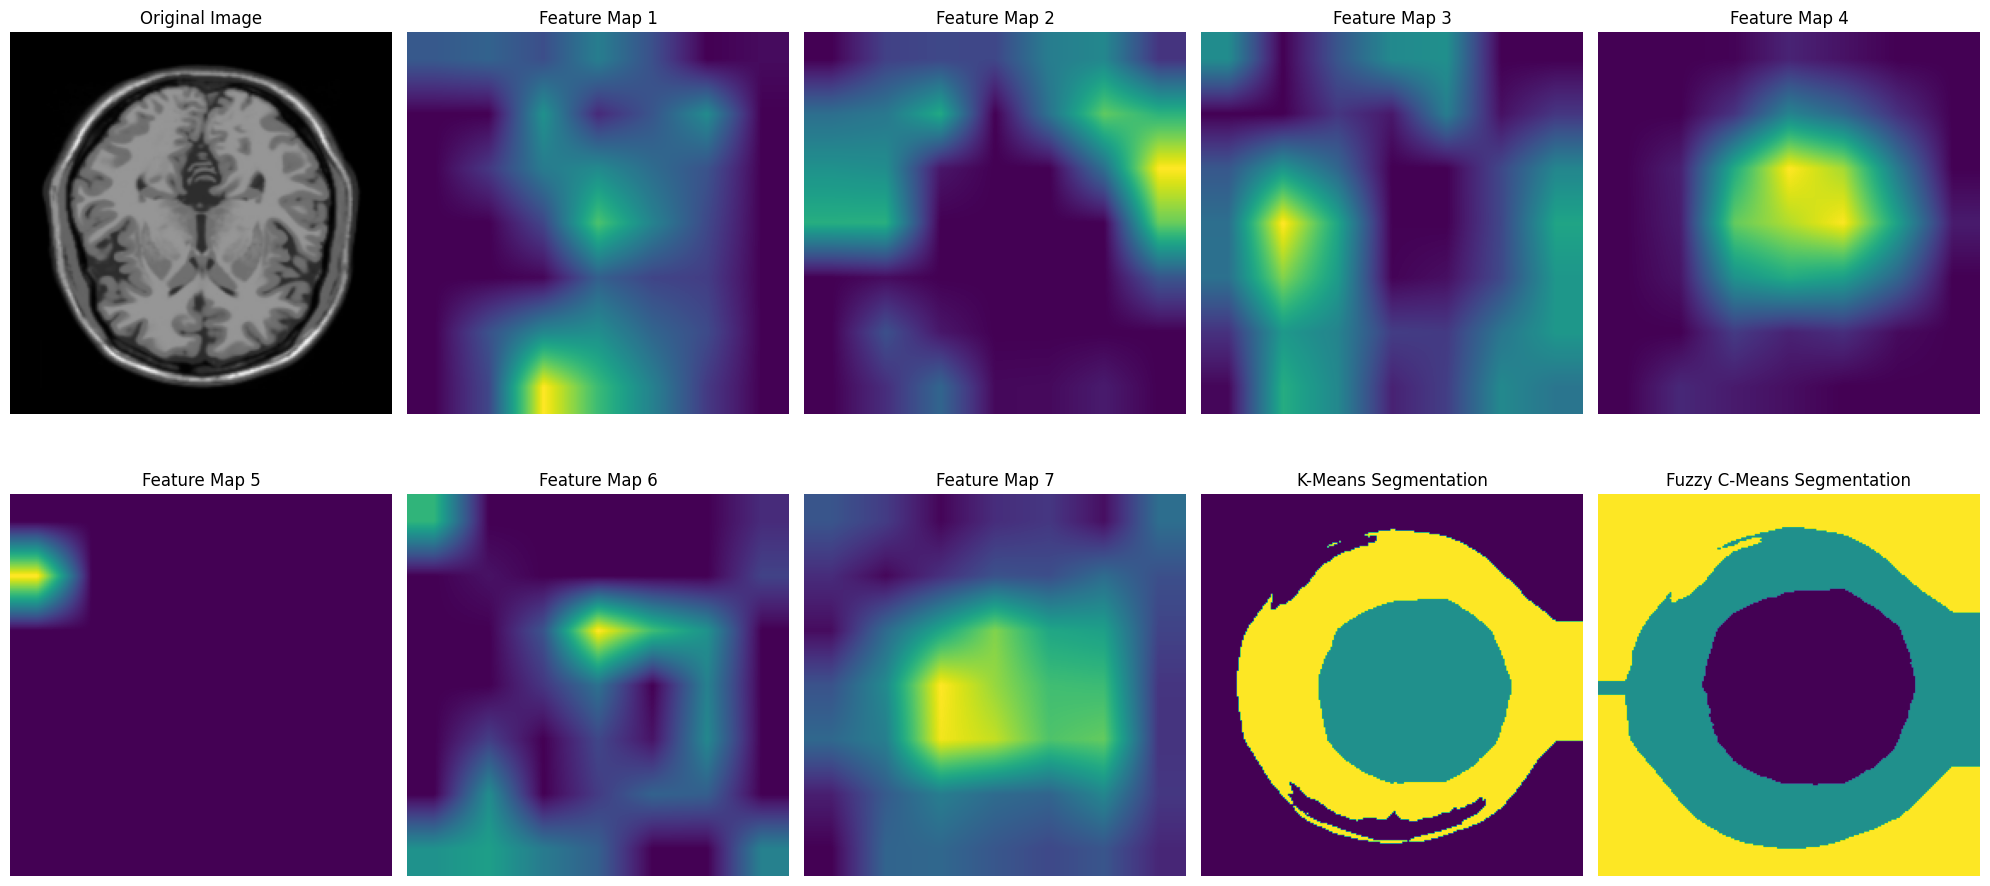

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


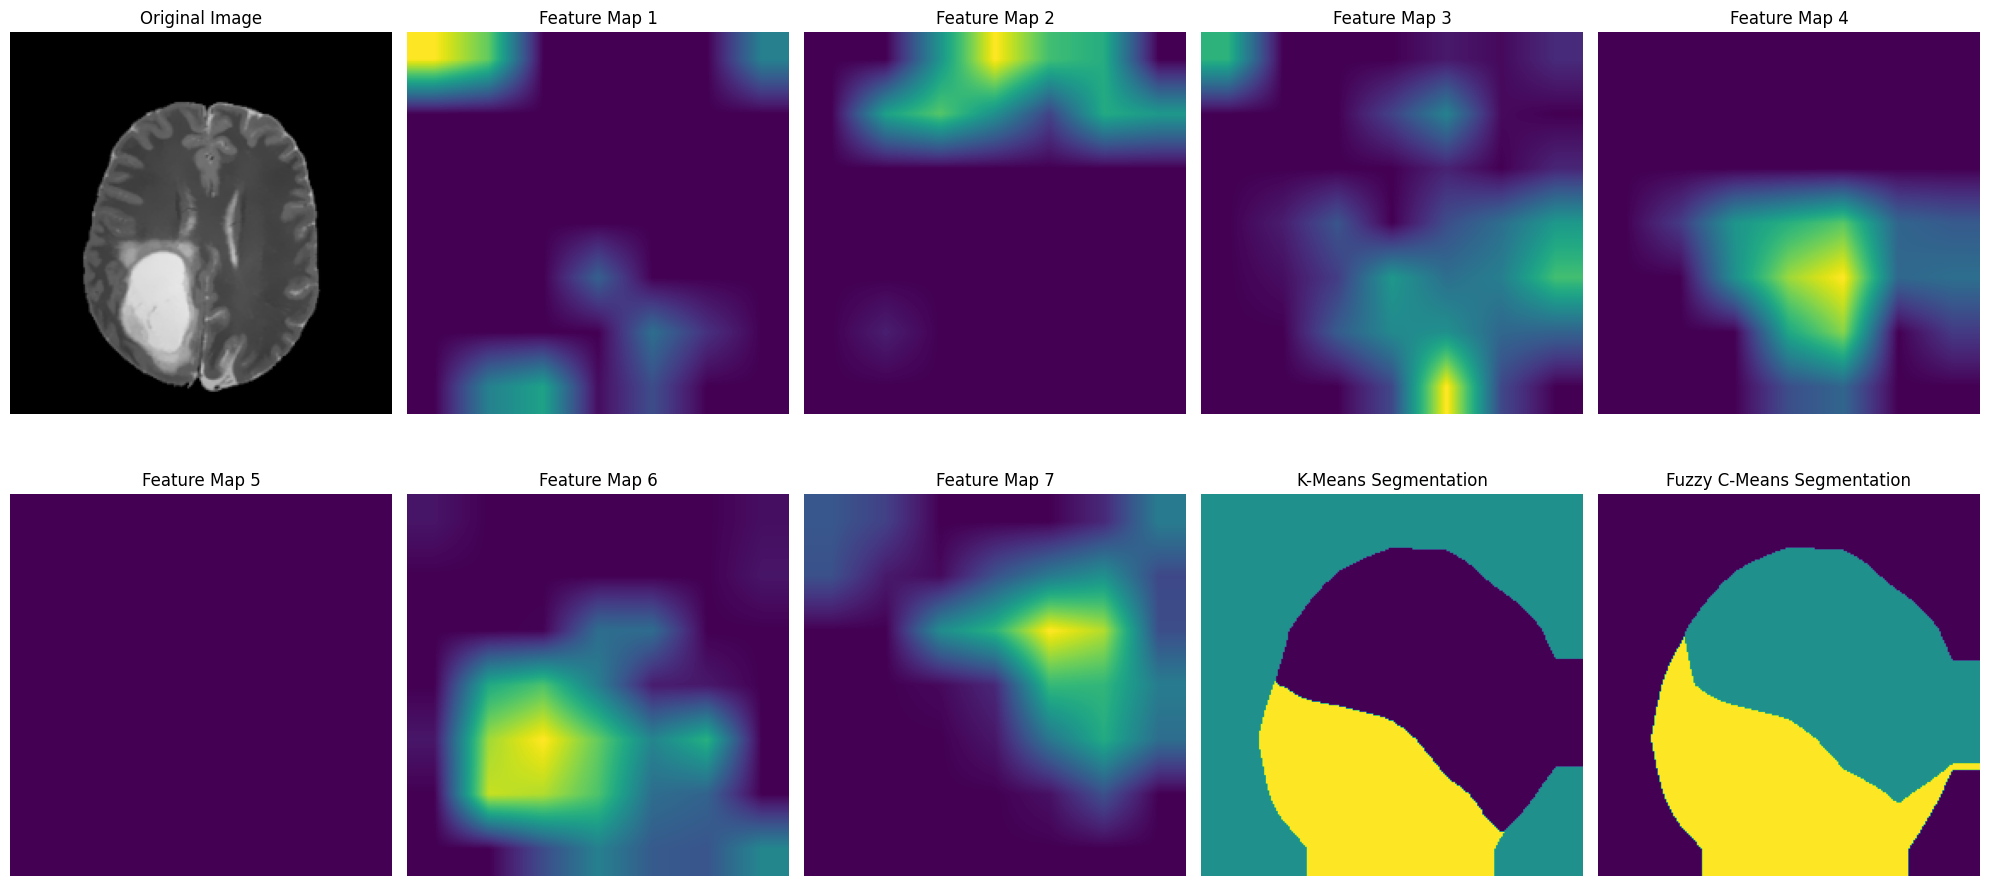

In [19]:
import os
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from skfuzzy import cmeans
import matplotlib.pyplot as plt

# Step 1: Load pretrained ResNet model
def load_resnet_model():
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.eval()  # Set to evaluation mode
    # Remove the final fully connected layer to get feature maps
    model = torch.nn.Sequential(*list(model.children())[:-2])
    return model

# Step 2: Preprocess and extract feature maps
def extract_feature_maps(image_path, model, device, target_size=(224, 224)):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, target_size)
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Extract feature maps
    with torch.no_grad():
        feature_maps = model(input_tensor)
    
    # Convert feature maps to numpy
    feature_maps = feature_maps.squeeze(0).cpu().numpy()  # Shape: (C, H', W')
    
    # Resize feature maps to match original image size using interpolation
    feature_maps_resized = []
    for i in range(feature_maps.shape[0]):
        fmap = feature_maps[i]
        fmap_resized = cv2.resize(fmap, target_size, interpolation=cv2.INTER_LINEAR)
        feature_maps_resized.append(fmap_resized)
    
    feature_maps_resized = np.array(feature_maps_resized)  # Shape: (C, H, W)
    
    return original_image, feature_maps_resized

# Step 3: Combine original image and feature maps
def combine_features(original_image, feature_maps):
    # Normalize original image to [0, 1]
    original_image = original_image.astype(float) / 255.0
    
    # Reshape images and feature maps for clustering
    h, w, c = original_image.shape
    original_flat = original_image.reshape(-1, c)  # Shape: (H*W, 3)
    
    # Normalize feature maps to [0, 1]
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())
    feature_maps_flat = feature_maps.transpose(1, 2, 0).reshape(-1, feature_maps.shape[0])  # Shape: (H*W, C)
    
    # Concatenate original image pixels and feature maps
    combined_features = np.concatenate([original_flat, feature_maps_flat], axis=1)  # Shape: (H*W, 3+C)
    
    return combined_features, h, w

# Step 4: K-Means segmentation
def kmeans_segmentation(combined_features, h, w, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(combined_features)
    segmented_image = labels.reshape(h, w)
    return segmented_image

# Step 5: Fuzzy C-Means segmentation
def fuzzy_cmeans_segmentation(combined_features, h, w, n_clusters=3):
    # Transpose data for fuzzy c-means (expects shape: (features, samples))
    cntr, u, _, _, _, _, _ = cmeans(combined_features.T, c=n_clusters, m=2, error=0.005, maxiter=1000)
    labels = np.argmax(u, axis=0)
    segmented_image = labels.reshape(h, w)
    return segmented_image

# Step 6: Visualize results including feature maps
def visualize_results(original_image, feature_maps, kmeans_result, fcm_result, image_path):
    plt.figure(figsize=(20, 10))
    
    # Original Image
    plt.subplot(2, 5, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')
    
    # Display a subset of feature maps (first 8 channels)
    num_feature_maps_to_show = min(8, feature_maps.shape[0])
    for i in range(num_feature_maps_to_show):
        plt.subplot(2, 5, i + 2)
        plt.title(f'Feature Map {i+1}')
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    
    # K-Means Segmentation
    plt.subplot(2, 5, 9)
    plt.title('K-Means Segmentation')
    plt.imshow(kmeans_result, cmap='viridis')
    plt.axis('off')
    
    # Fuzzy C-Means Segmentation
    plt.subplot(2, 5, 10)
    plt.title('Fuzzy C-Means Segmentation')
    plt.imshow(fcm_result, cmap='viridis')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main function to process all images in Q2 folder
def process_images(folder_path, n_clusters=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_resnet_model().to(device)
    
    for image_name in os.listdir(folder_path):
        if image_name.endswith(('.bmp', '.jpg')):
            image_path = os.path.join(folder_path, image_name)
            
            # Extract feature maps
            original_image, feature_maps = extract_feature_maps(image_path, model, device)
            
            # Combine features
            combined_features, h, w = combine_features(original_image, feature_maps)
            
            # Perform segmentation
            kmeans_result = kmeans_segmentation(combined_features, h, w, n_clusters)
            fcm_result = fuzzy_cmeans_segmentation(combined_features, h, w, n_clusters)
            
            # Visualize results
            visualize_results(original_image, feature_maps, kmeans_result, fcm_result, image_path)

if __name__ == '__main__':
    folder_path = '/kaggle/working/iMIAP/Assignment 2/Q2'  # Path to Q2 folder
    n_clusters = 3      # Number of clusters for segmentation
    process_images(folder_path, n_clusters)

## Part 3

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
# !{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!git clone https://github.com/Ehsanacc/iMIAP.git

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kfg0y83v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kfg0y83v
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-06-15 14:48:01--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  --

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


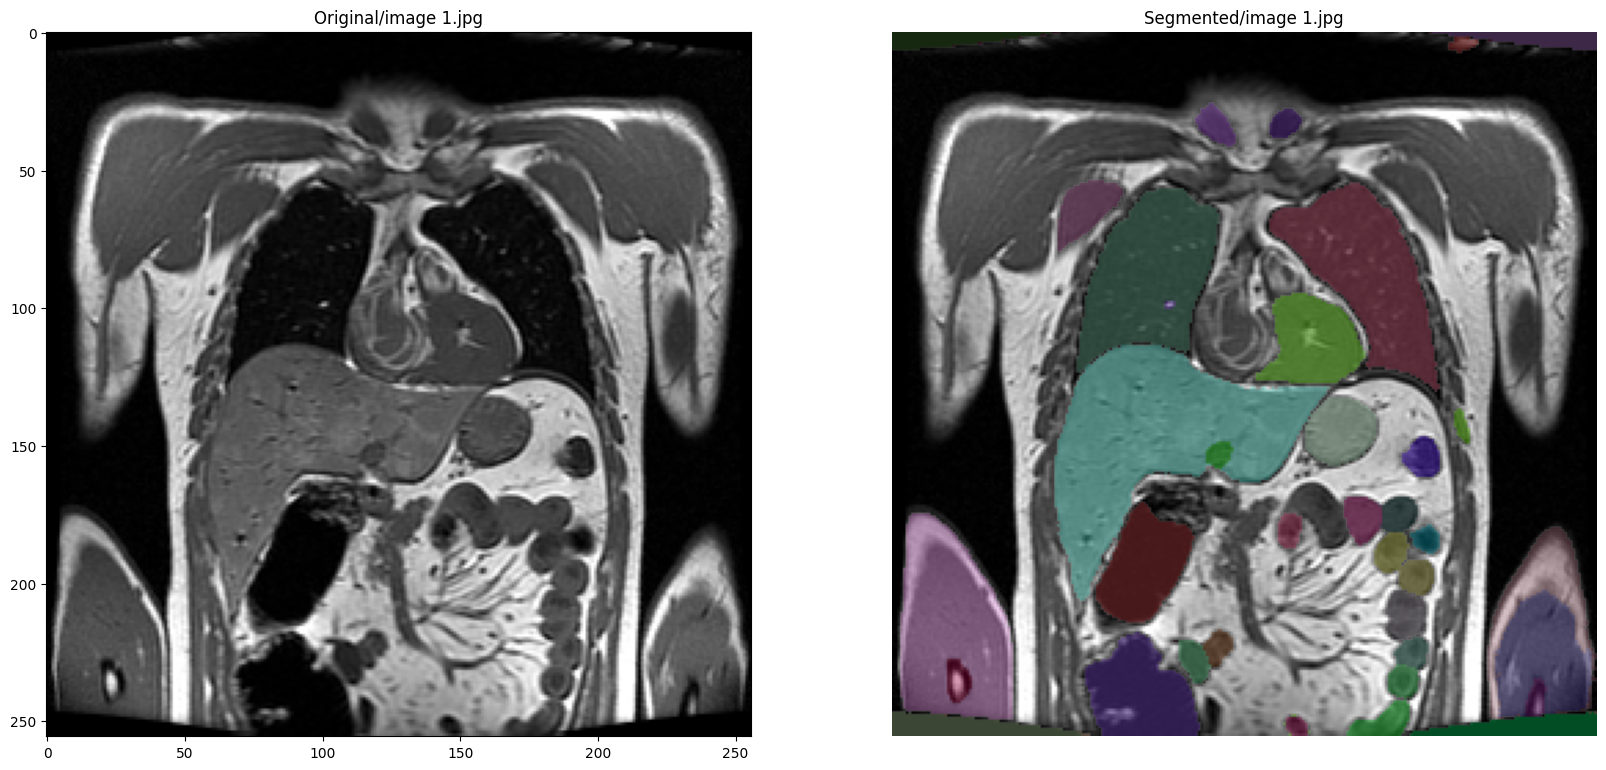

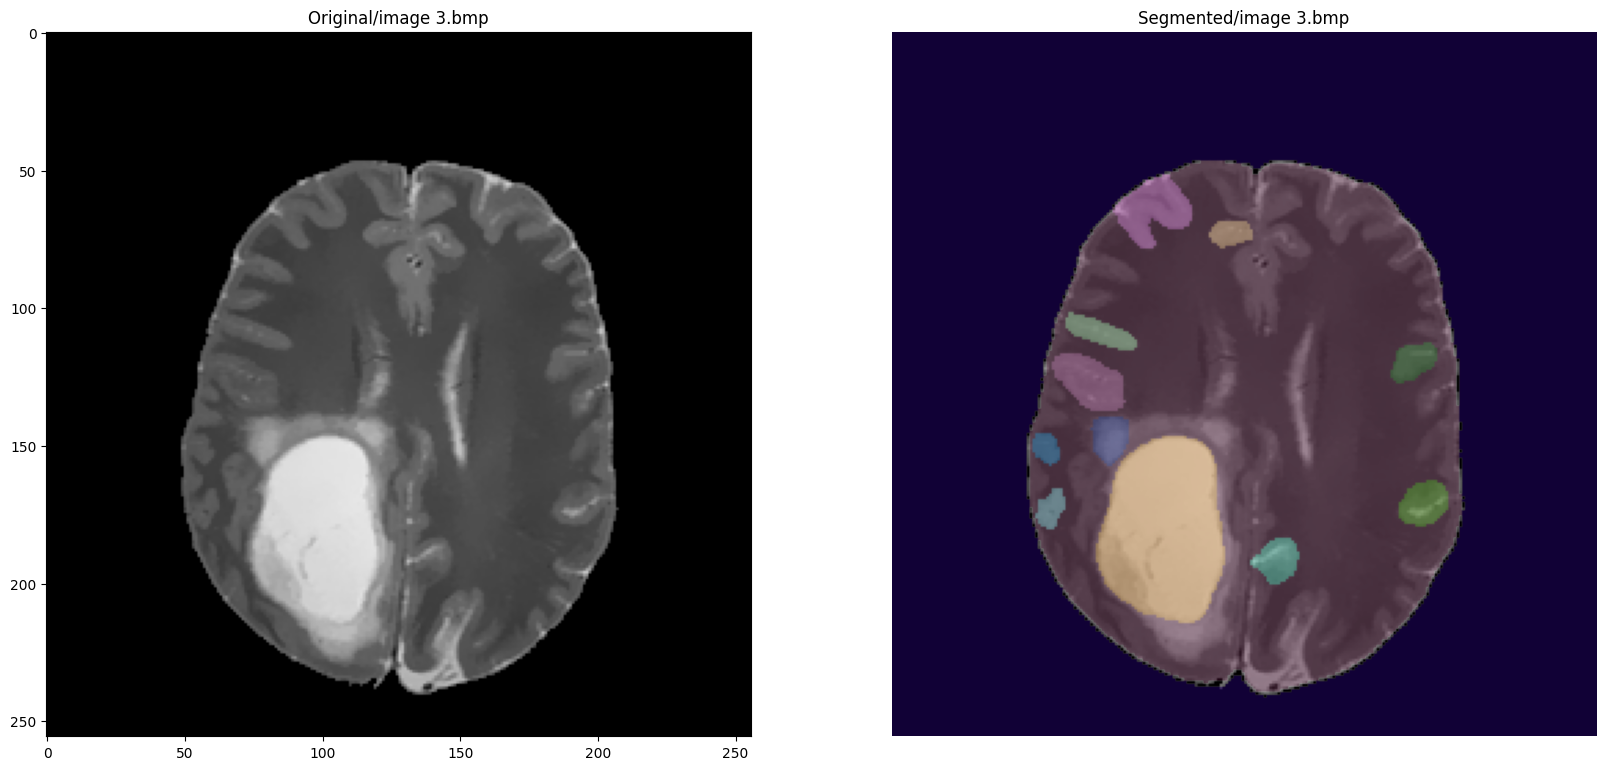

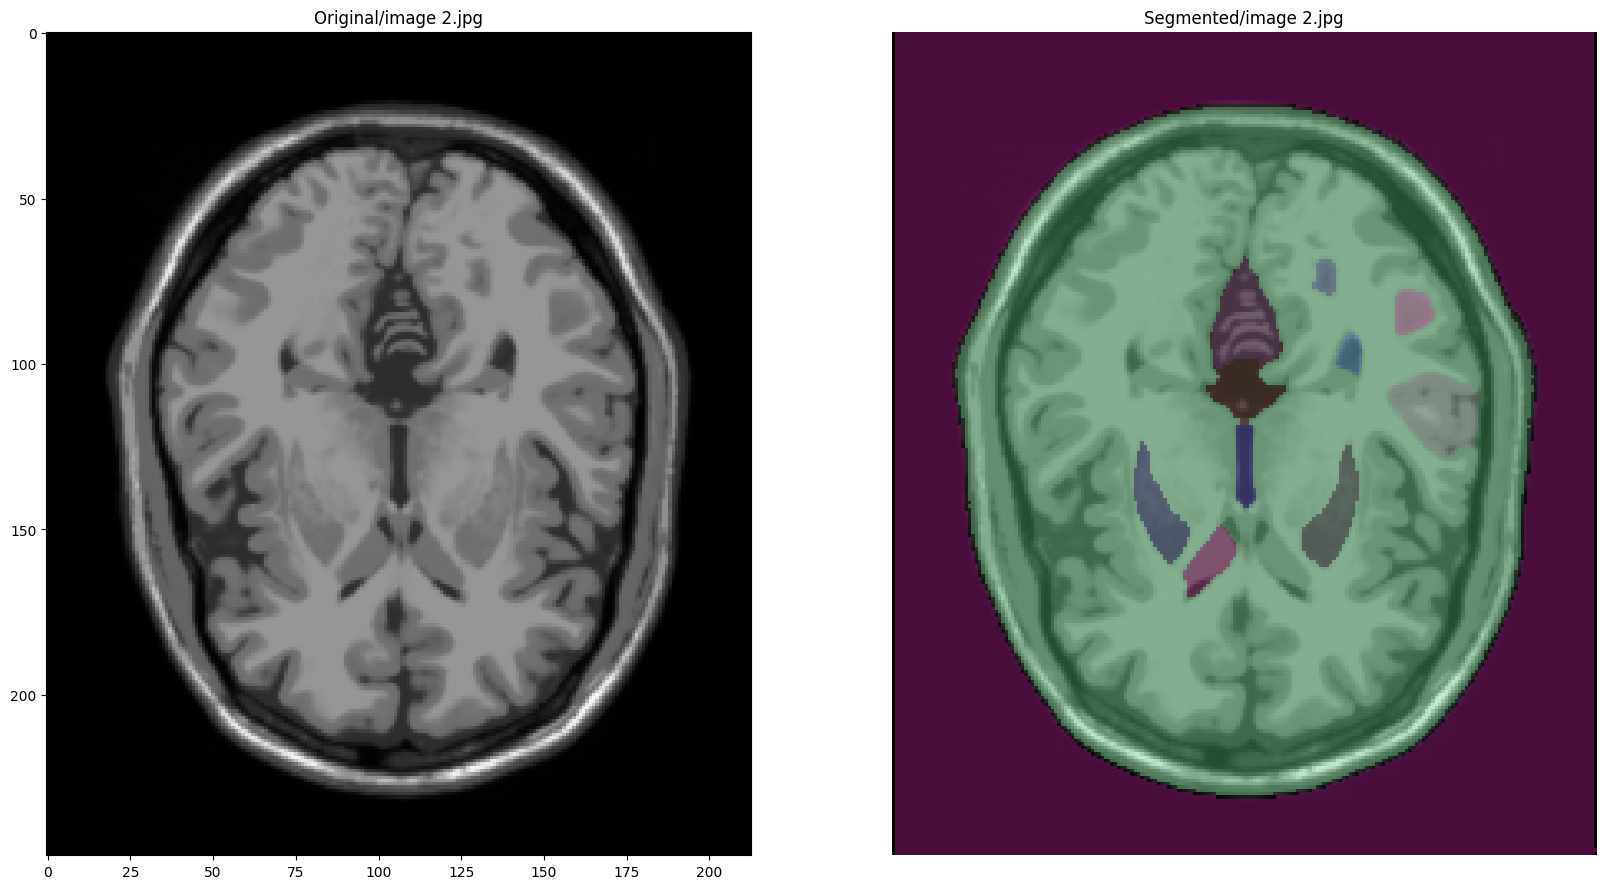

In [4]:
import os
import sys
sys.path.append("/")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


Q2_path = '/kaggle/working/iMIAP/Assignment 2/Q2'

for imageName in os.listdir(Q2_path):
    image = cv2.imread(os.path.join(Q2_path, imageName))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    
    plt.figure(figsize=(20,20))
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(os.path.join('Original', imageName))
    
    plt.subplot(1,2,2)
    plt.imshow(image)
    show_anns(masks)
    plt.axis('off')
    plt.title(os.path.join('Segmented', imageName))
    plt.show()